# Okinawa data visitor prediction using Regression method (Keras and Tensorflow)

### Import Libraries

In [1]:
! pip install seaborn

You should consider upgrading via the '/home/bidur/.virtualenvs/sm/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load the Dataset

In [3]:
preprocessed_data='/mnt/lv/bidur/OkinawaVisitorPred/data/2019-04_2019-08_GyokuSendo_staypoints.csv'

df=pd.read_csv(preprocessed_data)
df['date']= pd.to_datetime(df['date'])
df.head()

,date,month,day,car_count
0,2019-04-01,4,0,72
1,2019-04-02,4,1,66
2,2019-04-03,4,2,103
3,2019-04-04,4,3,89
4,2019-04-05,4,4,58


### Explore Data

In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
month,61.0,6.032787,2.016327,4.0,4.0,8.0,8.0,8.0
day,61.0,2.967213,2.008044,0.0,1.0,3.0,5.0,6.0
car_count,61.0,79.459016,16.777538,50.0,69.0,76.0,89.0,152.0


#### chek and remove null values , if any

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       61 non-null     datetime64[ns]
 1   month      61 non-null     int64         
 2   day        61 non-null     int64         
 3   car_count  61 non-null     int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 2.0 KB


In [6]:
df.isnull().sum()

date         0
month        0
day          0
car_count    0
dtype: int64

In [7]:
df.dropna(inplace=True)

### scatter plot

<AxesSubplot:xlabel='date', ylabel='car_count'>

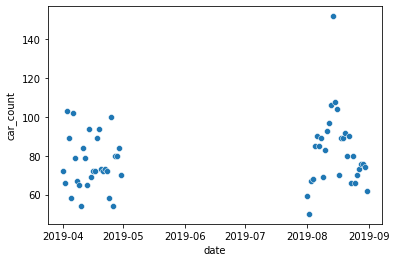

In [8]:
sns.scatterplot(data=df, x="date", y="car_count")

/home/bidur/.virtualenvs/sm/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='car_count', ylabel='Density'>

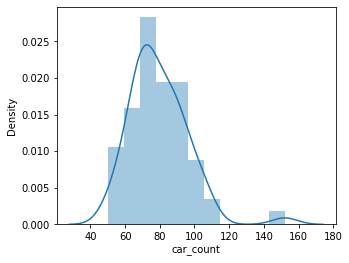

In [9]:
plt.figure(figsize=(5,4))
sns.distplot(df['car_count'])

### Check correlation among the variables

In [10]:
df.corr()

,month,day,car_count
month,1.000000,0.066132,0.186764
day,0.066132,1.000000,-0.057426
car_count,0.186764,-0.057426,1.000000


<AxesSubplot:>

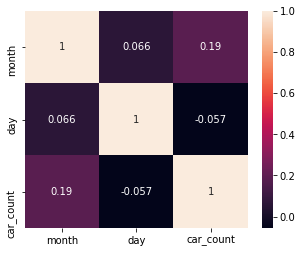

In [11]:
plt.figure(figsize=(5,4))
sns.heatmap(df.corr(), annot=True)

#### Drop date as we are not using it for prediction

In [12]:
df=df.drop('date', axis=1)
df.columns

Index(['month', 'day', 'car_count'], dtype='object')

# Convert categorical/nominal data into dummy/indicator variables
Categorical variables need to be recoded into a series of variables which can then be entered into the regression model. Here days ( Monday:0 ...Sunday:6) and months ( april:4....August:8) are such variables. To include them in a regression model, we will encode them accordingly.

In [13]:
X = df.drop('car_count',axis=1)
y = df['car_count']

In [14]:

X['day'] = X['day'].map({0: 'monday', 1: 'tuesday', 2: 'wednesday', 3: 'thursday', 4: 'friday', 5: 'saturday', 6: 'sunday' })
X = pd.get_dummies(X, prefix='', prefix_sep='',columns=['day'])
X.head(7)

,month,friday,monday,saturday,sunday,thursday,tuesday,wednesday
0,4,0,1,0,0,0,0,0
1,4,0,0,0,0,0,1,0
2,4,0,0,0,0,0,0,1
3,4,0,0,0,0,1,0,0
4,4,1,0,0,0,0,0,0
5,4,0,0,1,0,0,0,0
6,4,0,0,0,1,0,0,0


#### Now, apply for months

In [15]:
df.month.unique()

array([4, 8])

In [16]:
X['month'] = X['month'].map({1: 'Jan', 2: 'Feb',  3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec' })
X = pd.get_dummies(X, prefix='', prefix_sep='',columns=['month'])
X.head(2)

,friday,monday,saturday,sunday,thursday,tuesday,wednesday,April,Aug
0,0,1,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,1,0


# Scaling and Train Test Split

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

### Scaling

*The main idea behind normalization/standardization is always the same. Variables that are measured at different scales do not contribute equally to the model fitting & model learned function and might end up creating a bias. Thus, to deal with this potential problem feature-wise normalization such as MinMax Scaling is usually used prior to model fitting.* [Source:https://bit.ly/2KTulBB]

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
scaler = MinMaxScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#  Model Creation

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dropout
import keras

model = Sequential([
     Dense(64, activation='relu', input_shape=[X_test.shape[1]]),
     #Dropout(0.5), removing dropout improved in this particular example
     Dense(64, activation='relu'),
     Dense(1)
  ])

rmsprop = RMSprop(0.001)

model.compile(loss='mean_squared_error',
                optimizer=rmsprop,
                metrics=['mean_absolute_error', 'mean_squared_error'])

/home/bidur/.virtualenvs/sm/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bidur/.virtualenvs/sm/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bidur/.virtualenvs/sm/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bidur/.virtualenvs/sm/lib/python3.6/site-packages/tensorflow/

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/home/bidur/.virtualenvs/sm/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bidur/.virtualenvs/sm/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bidur/.virtualenvs/sm/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bidur/.virtualenvs/sm/lib/python3.6/site

### Training

In [ ]:
model.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=16,epochs=100) 

Train on 42 samples, validate on 19 samples


# Evaluation 

### Lets check the performance curves

In [ ]:
losses = pd.DataFrame(model.history.history)
losses.plot()

### Predictions

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [ ]:
predictions = model.predict(X_test)

In [ ]:
mae=mean_absolute_error(y_test,predictions)

In [ ]:
mse=mean_squared_error(y_test,predictions)

In [ ]:
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(y_test,predictions, squared=False)
mae,mse,rms

In [ ]:
predictions

In [ ]:
y_test